In [325]:
import pandas as pd
import numpy as np
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, davies_bouldin_score, completeness_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm

In [326]:
# Step 1: Load the processed data
file_path = '../data/final_team_cluster_data2.csv'
final_team_cluster_data = pd.read_csv(file_path)

In [327]:
# Add league information from the matches dataset
matches_file_path = '../data/ginf.csv'
matches_data = pd.read_csv(matches_file_path)
team_league_map = pd.concat([matches_data[['ht', 'league']], matches_data[['at', 'league']].rename(columns={'at': 'ht'})])
team_league_map = team_league_map.drop_duplicates().set_index('ht')['league'].to_dict()
final_team_cluster_data['league'] = final_team_cluster_data['event_team'].map(team_league_map)

In [328]:
# Verify that league column was added correctly
print("\nNumber of Teams from Each League:")
print(final_team_cluster_data['league'].value_counts())


Number of Teams from Each League:
league
F1     30
I1     30
SP1    30
E0     26
D1     26
Name: count, dtype: int64


In [329]:
# Step 2: Prepare data for clustering
team_names = final_team_cluster_data['event_team']
league_labels = final_team_cluster_data['league']  # Actual league labels
clustering_features = final_team_cluster_data.drop(columns=['event_team', 'league'])

In [330]:
# Step 3: Fine-tune BIRCH Hyperparameters
best_model = None
best_metrics = {'score': -np.inf}  # Use a custom scoring function
threshold_values = np.linspace(0.1, 0.9, 9)
n_clusters = 5  # Fixed to 5 for league clustering

In [331]:
# Define weights for the metrics
weights = {
    'silhouette': 0.4,   # Higher is better
    'davies_bouldin': -0.3,  # Lower is better (inverted weight)
    'ari': 0.15,         # Higher is better
    'homogeneity': 0.1,  # Higher is better
    'completeness': 0.05  # Higher is better
}

In [332]:
# Hyperparameter tuning loop
for threshold in tqdm(threshold_values, desc="Tuning BIRCH"):
    # Create and fit the BIRCH model
    birch_model = Birch(n_clusters=n_clusters, threshold=threshold)
    birch_model.fit(clustering_features)
    labels = birch_model.labels_

    # Compute metrics
    if len(set(labels)) > 1:  # Ensure more than one cluster exists
        silhouette = silhouette_score(clustering_features, labels)
        dbi = davies_bouldin_score(clustering_features, labels)
        ari = adjusted_rand_score(league_labels, labels)
        homogeneity = homogeneity_score(league_labels, labels)
        completeness = completeness_score(league_labels, labels)

        # Normalize Davies-Bouldin Index (lower is better, so invert it)
        dbi_score = 1 / (1 + dbi)  # Ensure it’s positive and bounded

        # Compute a weighted score
        weighted_score = (
            weights['silhouette'] * silhouette +
            weights['davies_bouldin'] * dbi_score +
            weights['ari'] * ari +
            weights['homogeneity'] * homogeneity +
            weights['completeness'] * completeness
        )

        # Save the best model based on the weighted score
        if weighted_score > best_metrics['score']:
            best_metrics = {
                'score': weighted_score,
                'silhouette': silhouette,
                'davies_bouldin': dbi,
                'ari': ari,
                'homogeneity': homogeneity,
                'completeness': completeness,
                'threshold': threshold
            }
            best_model = birch_model

Tuning BIRCH: 100%|██████████| 9/9 [00:00<00:00, 52.74it/s]


In [333]:
# Print the best hyperparameters and metrics
print("\nBest BIRCH Model:")
for metric, value in best_metrics.items():
    if metric != 'score':
        print(f"{metric.capitalize()}: {value:.2f}")
print(f"Weighted Score: {best_metrics['score']:.2f}")


Best BIRCH Model:
Silhouette: 0.17
Davies_bouldin: 1.75
Ari: 0.18
Homogeneity: 0.31
Completeness: 0.36
Threshold: 0.10
Weighted Score: 0.03


In [334]:
# Step 4: Assign Clusters Using the Best Model
final_team_cluster_data['cluster'] = best_model.labels_

In [335]:
# Step 5: Assign a League to Each Cluster (Advanced Approach)
# Create a DataFrame with cluster and league labels
cluster_league_df = final_team_cluster_data[['cluster', 'league']]

In [336]:
# Calculate league proportions within each cluster
league_distribution = cluster_league_df.groupby(['cluster', 'league']).size().unstack(fill_value=0)
league_distribution_normalized = league_distribution.div(league_distribution.sum(axis=1), axis=0)

In [337]:
# Actual league proportions
real_league_counts = final_team_cluster_data['league'].value_counts()
real_league_proportions = real_league_counts / real_league_counts.sum()

In [338]:
# Step 5a: Match Clusters to Leagues (Advanced Mapping)
from itertools import permutations

In [339]:
# Calculate total size for each cluster
cluster_sizes = cluster_league_df['cluster'].value_counts()

In [340]:
# Generate all possible mappings between clusters and leagues
possible_mappings = list(permutations(real_league_counts.index, len(league_distribution)))


In [341]:
# Function to calculate a "fit score" for a given mapping
def calculate_fit_score(mapping, cluster_sizes, league_distribution, real_league_proportions):
    score = 0
    for cluster, league in enumerate(mapping):
        # Alignment score: Match cluster distribution to league distribution
        cluster_league_proportion = league_distribution.iloc[cluster].get(league, 0)
        league_size_proportion = real_league_proportions.get(league, 0)
        size_penalty = abs(cluster_sizes[cluster] - real_league_counts[league]) / real_league_counts[league]
        
        # Higher weight to proportion match, lower weight to size penalty
        score += (0.7 * cluster_league_proportion) - (0.3 * size_penalty)
    return score

In [342]:
# Evaluate all possible mappings
best_mapping = None
best_score = -np.inf

for mapping in possible_mappings:
    score = calculate_fit_score(mapping, cluster_sizes, league_distribution, real_league_proportions)
    if score > best_score:
        best_score = score
        best_mapping = mapping

In [343]:
# Print the best mapping
print("\nBest Cluster-to-League Mapping:")
cluster_to_league_mapping = {cluster: league for cluster, league in enumerate(best_mapping)}
for cluster, league in cluster_to_league_mapping.items():
    print(f"Cluster {cluster}: {league}")


Best Cluster-to-League Mapping:
Cluster 0: D1
Cluster 1: E0
Cluster 2: F1
Cluster 3: I1
Cluster 4: SP1


In [344]:
# Step 5b: Assign leagues to clusters using the best mapping
final_team_cluster_data['predicted_league'] = final_team_cluster_data['cluster'].map(cluster_to_league_mapping)


In [345]:
# Step 6: Compute Accuracy
correct_predictions = final_team_cluster_data['predicted_league'] == final_team_cluster_data['league']
accuracy = correct_predictions.mean()
print(f"\nClustering Accuracy: {accuracy:.2f}")


Clustering Accuracy: 0.42


In [346]:
# Step 7: Evaluate Additional Metrics
ari = adjusted_rand_score(league_labels, final_team_cluster_data['cluster'])
homogeneity = homogeneity_score(league_labels, final_team_cluster_data['cluster'])
completeness = completeness_score(league_labels, final_team_cluster_data['cluster'])
dbi = davies_bouldin_score(clustering_features, final_team_cluster_data['cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.2f}")
print(f"Homogeneity Score: {homogeneity:.2f}")
print(f"Completeness Score: {completeness:.2f}")
print(f"Davies-Bouldin Index: {dbi:.2f}")

Adjusted Rand Index (ARI): 0.18
Homogeneity Score: 0.31
Completeness Score: 0.36
Davies-Bouldin Index: 1.75


In [347]:
# Cluster size distribution
cluster_counts = pd.Series(best_model.labels_).value_counts()
print("\nCluster Size Distribution:")
print(cluster_counts)


Cluster Size Distribution:
2    55
3    45
1    20
0    17
4     5
Name: count, dtype: int64


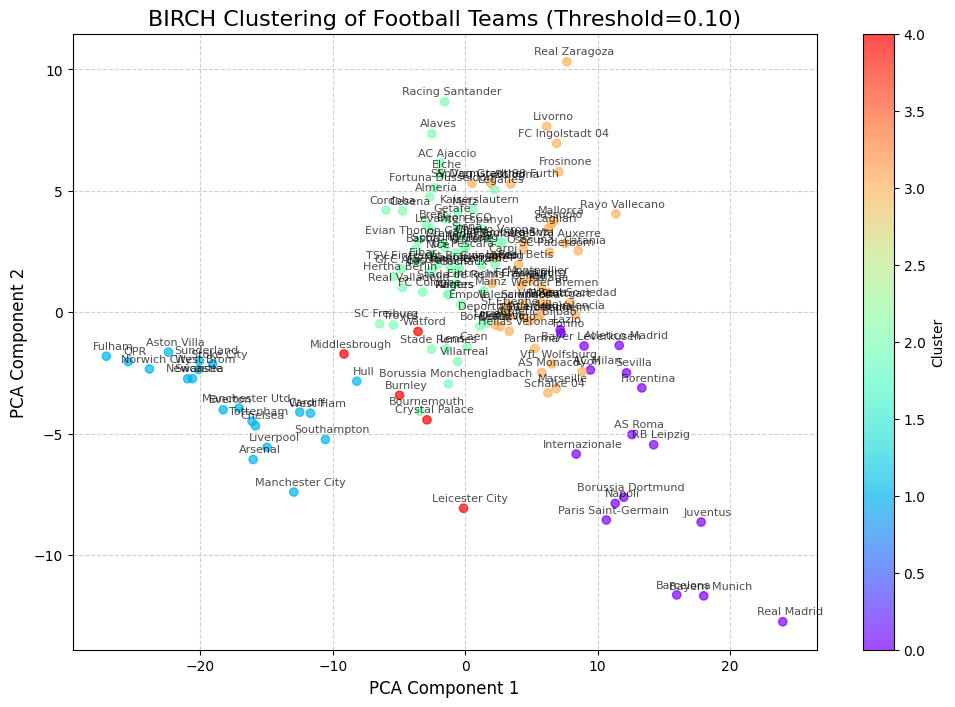

In [348]:
# Step 8: Visualize Clusters with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(clustering_features)
final_team_cluster_data['pca_x'] = pca_features[:, 0]
final_team_cluster_data['pca_y'] = pca_features[:, 1]

# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    final_team_cluster_data['pca_x'],
    final_team_cluster_data['pca_y'],
    c=final_team_cluster_data['cluster'],
    cmap='rainbow',
    alpha=0.7
)
plt.colorbar(scatter, label='Cluster')
plt.title(f'BIRCH Clustering of Football Teams (Threshold={best_metrics["threshold"]:.2f})', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)

# Annotate team names
for i, team in enumerate(team_names):
    plt.annotate(
        team,
        (final_team_cluster_data['pca_x'][i], final_team_cluster_data['pca_y'][i]),
        fontsize=8,
        alpha=0.7,
        textcoords="offset points",
        xytext=(5, 5),
        ha='center'
    )
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [349]:
# For curiosity, i want to see how many teams are from each league
print("\nNumber of Teams from Each League:")
print(final_team_cluster_data['league'].value_counts())


Number of Teams from Each League:
league
F1     30
I1     30
SP1    30
E0     26
D1     26
Name: count, dtype: int64
